_First code cell from custom template using [`jupyter_lab templates` extension](https://github.com/timkpaine/jupyterlab_templates)._

In [6]:
# To get multiple outputs from one code cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    get_ipython().run_line_magic('load_ext', 'autoreload')

%autoreload 2

%load_ext watermark
%watermark

import sys
from pathlib import Path

def sys_info():
    frmt = '\nPython ver: {}\nPython env: {}\n'
    frmt += 'OS:         {}\nCurrent dir: {}\n'
    print(frmt.format(sys.version, 
                      Path(sys.prefix).name,
                      sys.platform,
                      Path.cwd()))
sys_info()

def add_to_sys_path(this_path, up=False):
    """
    Prepend this_path to sys.path.
    If up=True, path refers to parent folder (1 level up).
    """
    newp = Path(this_path).as_posix() # no str method (?)
    if up:
        newp = Path(this_path).parent.as_posix()

    msg = F'Path already in sys.path: {newp}'
    if newp not in sys.path:
        sys.path.insert(1, newp)
        msg = F'Path added to sys.path: {newp}'
    print(msg)

# if notebook inside another folder, eg ./notebooks:
nb_folder = 'notebooks'
add_to_sys_path(Path.cwd(), Path.cwd().name.startswith(nb_folder))


# Filtered dir() for public method discovery:
def filter_dir(mdl, filter_str=None, start_with_str='_', exclude=True):
    """Filter dir(mdl) for method discovery.
       Input:
       :param mdl (object): module, optionally with submodule path(s), e.g. mdl.submdl1.submdl2.
       :param filter_str (str, None): filter all method names containing that string.
       :param start_with_str (str, '_'), exclude (bool, True): start_with_str and exclude work 
              together to perform search on non-dunder methods (default).
    """
    search_dir = [d for d in dir(mdl) if not d.startswith(start_with_str) == exclude]
    if filter_str is None:
        return search_dir
    else:
        filter_str = filter_str.lower()
        return [d for d in search_dir if d.lower().find(filter_str) != -1]


def get_project_dirs(which=['data', 'images'],
                     nb_folder='notebooks',
                     use_parent=True):
    '''Create folder(s) named in `which` at the parent level.'''
    dir_lst = []
    if Path.cwd().name.startswith(nb_folder) or use_parent:
        dir_fn = Path.cwd().parent.joinpath
    else:
        dir_fn = Path.cwd().joinpath
        
    for d in which:
        DIR = dir_fn(d)
        if not DIR.exists():
            Path.mkdir(DIR)
        dir_lst.append(DIR)
    return dir_lst

DIR_DATA, DIR_IMG = get_project_dirs()
    
import numpy as np
import scipy as sp
from scipy import stats as sps
import pandas as pd
#pd.set_option("display.max_colwidth", 200)

import matplotlib as mpl
from matplotlib import pyplot as plt
plt.ion()
plt.style.use('seaborn-muted')

def despine(which=['top','right']):
    '''
    which ([str])): 'left','top','right','bottom'.
    '''
    ax = plt.gca()
    for side in which:
        ax.spines[side].set_visible(False)

from IPython import get_ipython
from IPython.display import HTML, Markdown
# for presentations:
#display(HTML("<style>.container { width:100% !important; }</style>"))


def add_div(div_class='info', div_start='Tip:', 
            div_text='Some tip here', output_string=True):
    """
    Behaviour with default `output_string=True`:
    The cell is overwritten with the output, but the cell mode is still 'code',
    not 'markdown'.
    Workaround: After running the function, click on the new cell, press ESC, 
                type 'm', then run the new cell.
    If `output_string=False`, the output is displayed in an new cell with the 
    code cell visible.
    ```
    [x]
    add_div('alert-warning', 'Tip: ', 'some tip here', output_string=True)
    [x]
    <div class="alert alert-warning"><b>Tip: </b>some tip here</div>
    ```
    """
    accepted = ['info', 'warning', 'danger']
    div_class = div_class.lower()
    if div_class not in accepted:
        msg = f'<div class="alert"><b>Wrong class:&nbsp;</b> `div_start` not in: {accepted}.</div>'
        return Markdown(msg)
    
    div = f"""<div class="alert alert-{div_class}"><b>{div_start}&nbsp;&nbsp;</b>{div_text}</div>"""
    if output_string:
        return get_ipython().set_next_input(div, 'markdown')
    else:
        return Markdown(div)

    
def new_section(title='New section'):
    style = "text-align:center;background:#c2d3ef;padding:16px;color:#ffffff;font-size:2em;width:98%"
    div = f'<div style="{style}">{title}</div>'
    #return HTML('<div style="{}">{}</div>'.format(style, title))
    return get_ipython().set_next_input(div, 'markdown')


%watermark -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2020-09-16T16:47:59-04:00

CPython 3.7.6
IPython 7.16.1

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores  : 8
interpreter: 64bit

Python ver: 3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:11:50) [MSC v.1916 64 bit (AMD64)]
Python env: p37
OS:         win32
Current dir: C:\Users\catch\Documents\GitHub\Feasible_Region\notebooks

Path already in sys.path: C:/Users/catch/Documents/GitHub/Feasible_Region
scipy      1.5.0
matplotlib 3.3.1
pandas     1.0.5
numpy      1.19.0



---
---
# Plot of a feasible region for the given linear optimization constraints
---

---
# Implementation of a general `plot_feasible_region_2D` function

### Approach
* use of a `constraints dict` with specific naming convention: 
 * 0. constraints dict = dict(<id str>=(<series>, <label>)
 * 1. ids end with an integer: <str>_i
 * 2. x_0, y_0 would represent "0 constraints", i.e. x (or y) [>, <, >=,<=] 0

* plot the lines from constraints dict
* get the top and bottom y_series for the fillbetween function


### To do:
* Testing: input is 2D
* Testing: non_linear constraints: add warning: not all may work
* Testing: ...
* Implement: 3D version                                                                           

In [7]:
from feasible import fr_plotting as frplt

In [8]:
frplt?

Type:        module
String form: <module 'feasible.fr_plotting' from 'C:/Users/catch/Documents/GitHub/Feasible_Region\\feasible\\fr_plotting.py'>
File:        c:\users\catch\documents\github\feasible_region\feasible\fr_plotting.py
Docstring:  
Module `fr_plotting` contains functions used to obtain a plot of the feasible region of a linear programming problem given the constraints.

Version: beta
Needs further testing as of 2020, September


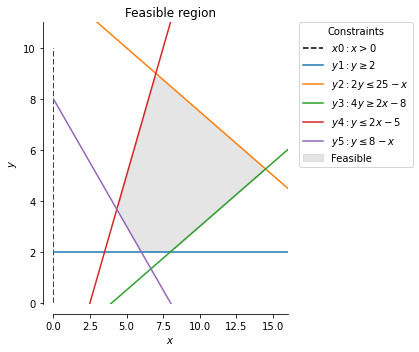

In [9]:
# domain
x = np.linspace(0, 20) #50 pts

# constraints dict
constraints = dict(
                   x_0=(x*0, r'$x0: x>0$'),
                   #y_0=(x*0, r'$y0: y>0$'),
                   y_1=(x*0 + 2, r'$y1: y\geq2$'),
                   y_2=((25-x)/2.0, r'$y2: 2y\leq25-x$'),
                   y_3=((2*x-8)/4.0, r'$y3: 4y\geq 2x - 8$'),
                   y_4=(2*x -5, r'$y4: y\leq 2x-5$'),
                   y_5=(8 -x, r'$y5: y\leq 8-x$'),
                   #y_6=(x*0 + 4, r'$y6: y\geq4$') #colinear case
                   )

# axis props:
ax_props = dict(xlim=(0, 16), ylim=(0, 11),
                xlabel=r'$x$', ylabel=r'$y$',
                title='Feasible region')

fig, ax = plt.subplots(figsize=(6,5))

frplt.plot_feasible_region_2D(ax, x, constraints, ax_props)

fn = DIR_IMG.joinpath('2D_with_x0line.png')
plt.savefig(fn)

plt.show();

## Constraints variants to try:

In [5]:
x = np.linspace(0, 20) #50 pts
constraints1 = dict(x_0=(x*0, r'$x0: x>0$'),
                   y_1=(x*0 + 2, r'$y1: y\geq2$'),
                   y_2=((25-x)/2.0, r'$y2: 2y\leq25-x$'),
                   y_3=((2*x-8)/4.0, r'$y3: 4y\geq 2x - 8$'),
                   y_4=(2*x -5, r'$y4: y\leq 2x-5$'),
                   )
constraints2 = dict(x_0=(x*0, r'$x0: x>0$'),
                   y_1=(x*0 + 2, r'$y1: y\geq2$'),
                   y_2=((25-x)/2.0, r'$y2: 2y\leq25-x$'),
                   y_3=((2*x-8)/4.0, r'$y3: 4y\geq 2x - 8$'),
                   y_4=(2*x -5, r'$y4: y\leq 2x-5$'),
                   y_5=(8 -x, r'$y5: y\leq 8-x$'),
                   )

constraints3 = dict(x_0=(x*0, r'$x0: x>0$'),
                   y_1=(x*0 + 2, r'$y1: y\geq2$'),
                   y_2=((25-x)/2.0, r'$y2: 2y\leq25-x$'),
                   y_3=((2*x-8)/4.0, r'$y3: 4y\geq 2x - 8$'),
                   y_4=(2*x -5, r'$y4: y\leq 2x-5$'),
                   y_5=(8 -x, r'$y5: y\leq 8-x$'),
                   y_6=(x*0 + 4, r'$y6: y\geq4$') #colinear w/ y_1
                   )
constraints4 = dict(x_0=(x*0, r'$x0: x>0$'),
                   #y_1=(x*0 + 2, r'$y1: y\geq2$'),
                   y_2=((25-x)/2.0, r'$y2: 2y\leq25-x$'),
                   y_3=((2*x-8)/4.0, r'$y3: 4y\geq 2x - 8$'),
                   y_4=(2*x -5, r'$y4: y\leq 2x-5$'),
                   y_5=(8 -x, r'$y5: y\leq 8-x$'),
                   y_6=(x*0 + 4, r'$y6: y\geq4$') 
                   )